In [1]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
source_dataset = "Dataset_Mahasiswa_D3TI22-Sidang-Haarcascade"
base_split_dir = "dataset_split_sidang_true32"

if not os.path.exists(base_split_dir):
    os.makedirs(base_split_dir)
    os.makedirs(os.path.join(base_split_dir, 'train'))
    os.makedirs(os.path.join(base_split_dir, 'val'))
    os.makedirs(os.path.join(base_split_dir, 'test'))

In [3]:
def split_data(source_path, dest_base_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    for class_name in os.listdir(source_path):
        class_path = os.path.join(source_path, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(dest_base_path, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img_name in split_imgs:
                src_path = os.path.join(class_path, img_name)
                dst_path = os.path.join(split_dir, img_name)
                shutil.copy2(src_path, dst_path)

In [4]:
split_data(source_dataset, base_split_dir)
print("Data berhasil di-split ke train, val, dan test")

Data berhasil di-split ke train, val, dan test


In [5]:
def count_images(base_dir):
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_dir, split)
        total = 0
        print(f"\n{split.upper()} SET:")
        for class_name in os.listdir(split_path):
            class_folder = os.path.join(split_path, class_name)
            n_images = len(os.listdir(class_folder))
            total += n_images
            print(f" - {class_name}: {n_images} gambar")
        print(f"Total {split}: {total} gambar")

count_images(base_split_dir)


TRAIN SET:
 - 11322005_Maria Sibarani: 45 gambar
 - 11322007_Putri: 45 gambar
 - 11322008_Maria Pangaribuan: 45 gambar
 - 11322009_Iqbal: 45 gambar
 - 11322012_Carloka: 45 gambar
 - 11322016_Horas: 45 gambar
 - 11322017_Jessica: 45 gambar
 - 11322018_Maranatha: 45 gambar
 - 11322019_Silvi: 45 gambar
 - 11322020_Okta: 45 gambar
 - 11322022_Keren: 45 gambar
 - 11322023_Mananda: 45 gambar
 - 11322026_Aqustin: 45 gambar
 - 11322027_Lenni: 45 gambar
 - 11322031_Daniel Manalu: 45 gambar
 - 11322032_Sabar: 45 gambar
 - 11322036_Tom: 45 gambar
 - 11322037_Hasan: 45 gambar
 - 11322038_Samuel: 45 gambar
 - 11322039_Kenan: 45 gambar
 - 11322041_Cecilia: 45 gambar
 - 11322042_Kesia: 45 gambar
 - 11322043_Risna: 45 gambar
 - 11322044_Kristina: 45 gambar
 - 11322046_Indah: 45 gambar
 - 11322047_Olivia: 45 gambar
 - 11322048_Resa: 45 gambar
 - 11322049_Trinita: 45 gambar
 - 11322050_Elisabeth: 45 gambar
 - 11322051_Sarah: 45 gambar
 - 11322052_Blessherin: 45 gambar
 - 11322057_Citra: 45 gambar
 - 11

In [6]:
IMG_SIZE = 224

# Train data generator dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Val dan Test tidak perlu augmentasi, hanya normalisasi
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_split_dir, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(base_split_dir, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(base_split_dir, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1710 images belonging to 38 classes.
Found 494 images belonging to 38 classes.
Found 266 images belonging to 38 classes.


# Modeling

In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [8]:
list_learning_rates = [1e-3, 1e-4]
list_dropout_rates = [0.3, 0.5]
list_dense_units = [64, 128]
list_batch_sizes = [32]
list_epochs = [50]

In [9]:
## Buat folder simpanan
os.makedirs("model32", exist_ok=True)
os.makedirs("plot32", exist_ok=True)

IMG_SIZE = 224
experiment_id = 0
hasil_eksperimen = []

best_val_acc = 0
best_model_path = ""

for lr in list_learning_rates:
    for dr in list_dropout_rates:
        for units in list_dense_units:
            for bs in list_batch_sizes:
                for ep in list_epochs:
                    experiment_id += 1
                    print(f"\nEksperimen {experiment_id}: lr={lr}, dropout={dr}, dense_units={units}, batch_size={bs}, epochs={ep}")

                    # Update batch size generator
                    train_gen.batch_size = bs
                    val_gen.batch_size = bs
                    test_gen.batch_size = bs

                    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
                    base_model.trainable = False

                    x = base_model.output
                    x = GlobalAveragePooling2D()(x)
                    x = Dropout(dr)(x)
                    x = Dense(units, activation='relu')(x)
                    outputs = Dense(train_gen.num_classes, activation='softmax')(x)

                    model = Model(inputs=base_model.input, outputs=outputs)
                    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

                    model.summary()
                    
                    model_path = f'model32/model_eksperimen_{experiment_id}.keras'
                    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=0)
                    earlystop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

                    history = model.fit(
                        train_gen,
                        validation_data=val_gen,
                        epochs=ep,
                        callbacks=[checkpoint, earlystop],
                        verbose=2
                    )

                    # Simpan grafik loss dan akurasi jika tersedia
                    if 'val_accuracy' in history.history and len(history.history['val_accuracy']) > 0:
                        plot_path = f'plot32/eksperimen_{experiment_id}.png'
                        plt.figure(figsize=(10, 4))

                        plt.subplot(1, 2, 1)
                        plt.plot(history.history['loss'], label='Train Loss')
                        plt.plot(history.history['val_loss'], label='Val Loss')
                        plt.title('Loss')
                        plt.legend()

                        plt.subplot(1, 2, 2)
                        plt.plot(history.history['accuracy'], label='Train Acc')
                        plt.plot(history.history['val_accuracy'], label='Val Acc')
                        plt.title('Accuracy')
                        plt.legend()

                        plt.suptitle(f'Eksperimen {experiment_id}')
                        plt.tight_layout()
                        plt.savefig(plot_path)
                        plt.close()

                    # Evaluasi model terbaik
                    best_model = load_model(model_path)
                    test_loss, test_acc = best_model.evaluate(test_gen, verbose=0)
                    y_pred_prob = best_model.predict(test_gen)
                    y_pred = np.argmax(y_pred_prob, axis=1)
                    y_true = test_gen.classes

                    report = classification_report(y_true, y_pred, output_dict=True)

                    hasil_eksperimen.append({
                        hasil_eksperimen.append({
                            'experiment_id': experiment_id,
                            'learning_rate': lr,
                            'dropout_rate': dr,
                            'dense_units': units,
                            'batch_size': bs,
                            'epochs': ep,
                            'train_acc_max(%)': round(max(history.history['accuracy']) * 100, 2),
                            'train_loss_min': round(min(history.history['loss']), 4),
                            'val_acc_max(%)': round(max(history.history['val_accuracy']) * 100, 2),
                            'val_loss_min': round(min(history.history['val_loss']), 4),
                            'test_accuracy(%)': round(test_acc * 100, 2),
                            'test_loss': round(test_loss, 4),
                            'precision(%)': round(report['weighted avg']['precision'] * 100, 2),
                            'recall(%)': round(report['weighted avg']['recall'] * 100, 2),
                            'f1_score(%)': round(report['weighted avg']['f1-score'] * 100, 2)
                        })

                    })

                    # Simpan path model terbaik secara global
                    if max(history.history['val_accuracy']) > best_val_acc:
                        best_val_acc = max(history.history['val_accuracy'])
                        best_model_path = model_path


Eksperimen 1: lr=0.001, dropout=0.3, dense_units=64, batch_size=32, epochs=50


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,342,438 (8.94 MB)

 Trainable params: 84,454 (329.90 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50


C:\Users\pc-lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 - 91s - 2s/step - accuracy: 0.0450 - loss: 3.6299 - val_accuracy: 0.0891 - val_loss: 3.4731
Epoch 2/50
54/54 - 78s - 1s/step - accuracy: 0.1357 - loss: 3.2948 - val_accuracy: 0.2146 - val_loss: 2.9331
Epoch 3/50
54/54 - 77s - 1s/step - accuracy: 0.2327 - loss: 2.8706 - val_accuracy: 0.3340 - val_loss: 2.5421
Epoch 4/50
54/54 - 77s - 1s/step - accuracy: 0.3211 - loss: 2.5212 - val_accuracy: 0.3846 - val_loss: 2.2454
Epoch 5/50
54/54 - 79s - 1s/step - accuracy: 0.3977 - loss: 2.2487 - val_accuracy: 0.4899 - val_loss: 1.9630
Epoch 6/50
54/54 - 81s - 1s/step - accuracy: 0.4567 - loss: 2.0662 - val_accuracy: 0.5405 - val_loss: 1.7833
Epoch 7/50
54/54 - 102s - 2s/step - accuracy: 0.4819 - loss: 1.9354 - val_accuracy: 0.5891 - val_loss: 1.6381
Epoch 8/50
54/54 - 101s - 2s/step - accuracy: 0.4959 - loss: 1.8242 - val_accuracy: 0.6194 - val_loss: 1.5410
Epoch 9/50
54/54 - 95s - 2s/step - accuracy: 0.5439 - loss: 1.6663 - val_accuracy: 0.6457 - val_loss: 1.4420
Epoch 10/50
54/54 - 97s - 2s

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
54/54 - 123s - 2s/step - accuracy: 0.0725 - loss: 3.5716 - val_accuracy: 0.2409 - val_loss: 3.0677
Epoch 2/50
54/54 - 103s - 2s/step - accuracy: 0.2491 - loss: 2.9181 - val_accuracy: 0.4109 - val_loss: 2.3558
Epoch 3/50
54/54 - 105s - 2s/step - accuracy: 0.3626 - loss: 2.3686 - val_accuracy: 0.5223 - val_loss: 1.8647
Epoch 4/50
54/54 - 104s - 2s/step - accuracy: 0.4690 - loss: 1.9689 - val_accuracy: 0.5891 - val_loss: 1.5805
Epoch 5/50
54/54 - 104s - 2s/step - accuracy: 0.5164 - loss: 1.7875 - val_accuracy: 0.6174 - val_loss: 1.4329
Epoch 6/50
54/54 - 105s - 2s/step - accuracy: 0.5456 - loss: 1.6253 - val_accuracy: 0.6478 - val_loss: 1.2835
Epoch 7/50
54/54 - 105s - 2s/step - accuracy: 0.6047 - loss: 1.4498 - val_accuracy: 0.7024 - val_loss: 1.1494
Epoch 8/50
54/54 - 105s - 2s/step - accuracy: 0.6304 - loss: 1.3683 - val_accuracy: 0.7105 - val_loss: 1.1103
Epoch 9/50
54/54 - 104s - 2s/step - accuracy: 0.6456 - loss: 1.3008 - val_accuracy: 0.7652 - val_loss: 1.0009
Epoch 10/5

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,342,438 (8.94 MB)

 Trainable params: 84,454 (329.90 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
54/54 - 87s - 2s/step - accuracy: 0.0398 - loss: 3.7081 - val_accuracy: 0.0547 - val_loss: 3.5396
Epoch 2/50
54/54 - 75s - 1s/step - accuracy: 0.0901 - loss: 3.4529 - val_accuracy: 0.1903 - val_loss: 3.1806
Epoch 3/50
54/54 - 76s - 1s/step - accuracy: 0.1509 - loss: 3.1964 - val_accuracy: 0.2490 - val_loss: 2.7851
Epoch 4/50
54/54 - 74s - 1s/step - accuracy: 0.2322 - loss: 2.8607 - val_accuracy: 0.3907 - val_loss: 2.3791
Epoch 5/50
54/54 - 73s - 1s/step - accuracy: 0.3082 - loss: 2.5631 - val_accuracy: 0.4514 - val_loss: 2.1593
Epoch 6/50
54/54 - 71s - 1s/step - accuracy: 0.3550 - loss: 2.3482 - val_accuracy: 0.5081 - val_loss: 1.9117
Epoch 7/50
54/54 - 75s - 1s/step - accuracy: 0.3877 - loss: 2.2332 - val_accuracy: 0.5425 - val_loss: 1.7731
Epoch 8/50
54/54 - 73s - 1s/step - accuracy: 0.4135 - loss: 2.0583 - val_accuracy: 0.5789 - val_loss: 1.6535
Epoch 9/50
54/54 - 75s - 1s/step - accuracy: 0.4684 - loss: 1.9424 - val_accuracy: 0.5810 - val_loss: 1.5607
Epoch 10/50
54/54 -

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
54/54 - 85s - 2s/step - accuracy: 0.0737 - loss: 3.6627 - val_accuracy: 0.1700 - val_loss: 3.2912
Epoch 2/50
54/54 - 75s - 1s/step - accuracy: 0.1421 - loss: 3.2263 - val_accuracy: 0.2955 - val_loss: 2.6537
Epoch 3/50
54/54 - 73s - 1s/step - accuracy: 0.2585 - loss: 2.7545 - val_accuracy: 0.3785 - val_loss: 2.3319
Epoch 4/50
54/54 - 74s - 1s/step - accuracy: 0.3298 - loss: 2.4957 - val_accuracy: 0.5425 - val_loss: 1.8752
Epoch 5/50
54/54 - 73s - 1s/step - accuracy: 0.3953 - loss: 2.2208 - val_accuracy: 0.5364 - val_loss: 1.7292
Epoch 6/50
54/54 - 74s - 1s/step - accuracy: 0.4421 - loss: 2.0057 - val_accuracy: 0.5931 - val_loss: 1.5147
Epoch 7/50
54/54 - 79s - 1s/step - accuracy: 0.4760 - loss: 1.8906 - val_accuracy: 0.6660 - val_loss: 1.3525
Epoch 8/50
54/54 - 75s - 1s/step - accuracy: 0.5234 - loss: 1.7439 - val_accuracy: 0.6883 - val_loss: 1.2956
Epoch 9/50
54/54 - 77s - 1s/step - accuracy: 0.5228 - loss: 1.6943 - val_accuracy: 0.6761 - val_loss: 1.2070
Epoch 10/50
54/54 -

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,342,438 (8.94 MB)

 Trainable params: 84,454 (329.90 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
54/54 - 111s - 2s/step - accuracy: 0.0287 - loss: 3.8100 - val_accuracy: 0.0304 - val_loss: 3.6232
Epoch 2/50
54/54 - 96s - 2s/step - accuracy: 0.0439 - loss: 3.6494 - val_accuracy: 0.0607 - val_loss: 3.5757
Epoch 3/50
54/54 - 95s - 2s/step - accuracy: 0.0520 - loss: 3.5787 - val_accuracy: 0.0648 - val_loss: 3.5369
Epoch 4/50
54/54 - 100s - 2s/step - accuracy: 0.0667 - loss: 3.5456 - val_accuracy: 0.0688 - val_loss: 3.4876
Epoch 5/50
54/54 - 98s - 2s/step - accuracy: 0.0690 - loss: 3.5046 - val_accuracy: 0.0870 - val_loss: 3.4343
Epoch 6/50
54/54 - 104s - 2s/step - accuracy: 0.0784 - loss: 3.4649 - val_accuracy: 0.1113 - val_loss: 3.3694
Epoch 7/50
54/54 - 93s - 2s/step - accuracy: 0.1123 - loss: 3.3885 - val_accuracy: 0.1498 - val_loss: 3.2883
Epoch 8/50
54/54 - 82s - 2s/step - accuracy: 0.1187 - loss: 3.3644 - val_accuracy: 0.1599 - val_loss: 3.2196
Epoch 9/50
54/54 - 81s - 1s/step - accuracy: 0.1257 - loss: 3.2863 - val_accuracy: 0.1721 - val_loss: 3.1474
Epoch 10/50
54/5

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
54/54 - 88s - 2s/step - accuracy: 0.0322 - loss: 3.8408 - val_accuracy: 0.0628 - val_loss: 3.5987
Epoch 2/50
54/54 - 76s - 1s/step - accuracy: 0.0468 - loss: 3.6439 - val_accuracy: 0.1012 - val_loss: 3.4604
Epoch 3/50
54/54 - 74s - 1s/step - accuracy: 0.0789 - loss: 3.4979 - val_accuracy: 0.1397 - val_loss: 3.3423
Epoch 4/50
54/54 - 73s - 1s/step - accuracy: 0.1140 - loss: 3.4201 - val_accuracy: 0.1842 - val_loss: 3.2095
Epoch 5/50
54/54 - 69s - 1s/step - accuracy: 0.1199 - loss: 3.3151 - val_accuracy: 0.2206 - val_loss: 3.0852
Epoch 6/50
54/54 - 71s - 1s/step - accuracy: 0.1532 - loss: 3.1958 - val_accuracy: 0.2591 - val_loss: 2.9524
Epoch 7/50
54/54 - 72s - 1s/step - accuracy: 0.1942 - loss: 3.0912 - val_accuracy: 0.2996 - val_loss: 2.8183
Epoch 8/50
54/54 - 78s - 1s/step - accuracy: 0.2058 - loss: 2.9695 - val_accuracy: 0.3300 - val_loss: 2.7058
Epoch 9/50
54/54 - 103s - 2s/step - accuracy: 0.2608 - loss: 2.8416 - val_accuracy: 0.3806 - val_loss: 2.5845
Epoch 10/50
54/54 

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,342,438 (8.94 MB)

 Trainable params: 84,454 (329.90 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
54/54 - 102s - 2s/step - accuracy: 0.0281 - loss: 3.9782 - val_accuracy: 0.0405 - val_loss: 3.6238
Epoch 2/50
54/54 - 74s - 1s/step - accuracy: 0.0333 - loss: 3.7551 - val_accuracy: 0.0526 - val_loss: 3.5834
Epoch 3/50
54/54 - 70s - 1s/step - accuracy: 0.0363 - loss: 3.6723 - val_accuracy: 0.0749 - val_loss: 3.5696
Epoch 4/50
54/54 - 75s - 1s/step - accuracy: 0.0333 - loss: 3.6469 - val_accuracy: 0.0830 - val_loss: 3.5582
Epoch 5/50
54/54 - 72s - 1s/step - accuracy: 0.0532 - loss: 3.6285 - val_accuracy: 0.0810 - val_loss: 3.5448
Epoch 6/50
54/54 - 69s - 1s/step - accuracy: 0.0520 - loss: 3.5818 - val_accuracy: 0.1053 - val_loss: 3.5307
Epoch 7/50
54/54 - 69s - 1s/step - accuracy: 0.0661 - loss: 3.5677 - val_accuracy: 0.1073 - val_loss: 3.5003
Epoch 8/50
54/54 - 69s - 1s/step - accuracy: 0.0725 - loss: 3.5291 - val_accuracy: 0.1417 - val_loss: 3.4609
Epoch 9/50
54/54 - 72s - 1s/step - accuracy: 0.0690 - loss: 3.5076 - val_accuracy: 0.1437 - val_loss: 3.4158
Epoch 10/50
54/54 

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
54/54 - 84s - 2s/step - accuracy: 0.0275 - loss: 4.0235 - val_accuracy: 0.0567 - val_loss: 3.6149
Epoch 2/50
54/54 - 76s - 1s/step - accuracy: 0.0409 - loss: 3.7493 - val_accuracy: 0.0789 - val_loss: 3.5140
Epoch 3/50
54/54 - 75s - 1s/step - accuracy: 0.0561 - loss: 3.6482 - val_accuracy: 0.0931 - val_loss: 3.4430
Epoch 4/50
54/54 - 75s - 1s/step - accuracy: 0.0667 - loss: 3.6034 - val_accuracy: 0.1296 - val_loss: 3.3890
Epoch 5/50
54/54 - 74s - 1s/step - accuracy: 0.0901 - loss: 3.5234 - val_accuracy: 0.1518 - val_loss: 3.3308
Epoch 6/50
54/54 - 72s - 1s/step - accuracy: 0.1000 - loss: 3.4545 - val_accuracy: 0.1660 - val_loss: 3.2678
Epoch 7/50
54/54 - 72s - 1s/step - accuracy: 0.0982 - loss: 3.3915 - val_accuracy: 0.1883 - val_loss: 3.1939
Epoch 8/50
54/54 - 73s - 1s/step - accuracy: 0.1158 - loss: 3.3443 - val_accuracy: 0.2186 - val_loss: 3.1155
Epoch 9/50
54/54 - 73s - 1s/step - accuracy: 0.1409 - loss: 3.2578 - val_accuracy: 0.2348 - val_loss: 3.0415
Epoch 10/50
54/54 -

In [12]:
for i, item in enumerate(hasil_eksperimen[:5]):
    print(f"{i}: {item} - {type(item)}")

0: {'experiment_id': 1, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'dense_units': 64, 'batch_size': 32, 'epochs': 50, 'train_acc_max(%)': 79.06, 'train_loss_min': 0.7096, 'val_acc_max(%)': 81.38, 'val_loss_min': 0.6657, 'test_accuracy(%)': 82.33, 'test_loss': 0.6926, 'precision(%)': 85.19, 'recall(%)': 82.33, 'f1_score(%)': 81.95} - <class 'dict'>
1: {None} - <class 'set'>
2: {'experiment_id': 2, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'dense_units': 128, 'batch_size': 32, 'epochs': 50, 'train_acc_max(%)': 83.68, 'train_loss_min': 0.5564, 'val_acc_max(%)': 86.23, 'val_loss_min': 0.5604, 'test_accuracy(%)': 84.96, 'test_loss': 0.6059, 'precision(%)': 87.46, 'recall(%)': 84.96, 'f1_score(%)': 84.8} - <class 'dict'>
3: {None} - <class 'set'>
4: {'experiment_id': 3, 'learning_rate': 0.001, 'dropout_rate': 0.5, 'dense_units': 64, 'batch_size': 32, 'epochs': 50, 'train_acc_max(%)': 72.87, 'train_loss_min': 0.9394, 'val_acc_max(%)': 81.17, 'val_loss_min': 0.6954, 'test_accuracy(%)': 79

In [13]:
hasil_eksperimen_bersih = [item for item in hasil_eksperimen if isinstance(item, dict)]

df_hasil = pd.DataFrame(hasil_eksperimen_bersih)
df_hasil.to_csv("hasil_semua_eksperimen7.csv", index=False)

print("Semua hasil eksperimen berhasil disimpan ke 'hasil_semua_eksperimen7.csv'")
df_hasil.head()

Semua hasil eksperimen berhasil disimpan ke 'hasil_semua_eksperimen7.csv'


,experiment_id,learning_rate,dropout_rate,dense_units,batch_size,epochs,train_acc_max(%),train_loss_min,val_acc_max(%),val_loss_min,test_accuracy(%),test_loss,precision(%),recall(%),f1_score(%)
0,1,0.0010,0.3,64,32,50,79.06,0.7096,81.38,0.6657,82.33,0.6926,85.19,82.33,81.95
1,2,0.0010,0.3,128,32,50,83.68,0.5564,86.23,0.5604,84.96,0.6059,87.46,84.96,84.80
2,3,0.0010,0.5,64,32,50,72.87,0.9394,81.17,0.6954,79.32,0.7488,83.72,79.32,79.08
3,4,0.0010,0.5,128,32,50,75.96,0.7941,84.41,0.6268,83.83,0.6772,86.07,83.83,83.70
4,5,0.0001,0.3,64,32,50,59.36,1.5986,69.43,1.3895,65.04,1.4972,71.59,65.04,64.16


In [14]:
print(f"Model terbaik: {best_model_path}")
model_terbaik = load_model(best_model_path)

# Tampilkan arsitektur model
model_terbaik.summary()

# Evaluasi ulang di test set
test_loss, test_acc = model_terbaik.evaluate(test_gen, verbose=0)
print(f" Akurasi test: {test_acc * 100:.2f}%")
print(f" Loss test: {test_loss:.4f}")

# Tampilkan konfigurasi dari DataFrame
print("Konfigurasi model terbaik:")
print(df_hasil[df_hasil['val_acc_max(%)'] == df_hasil['val_acc_max(%)'].max()])

Model terbaik: model32/model_eksperimen_2.keras


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,764,596 (10.55 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 337,742 (1.29 MB)

 Akurasi test: 84.96%
 Loss test: 0.6059
Konfigurasi model terbaik:
   experiment_id  learning_rate  dropout_rate  dense_units  batch_size  \
1              2          0.001           0.3          128          32   

   epochs  train_acc_max(%)  train_loss_min  val_acc_max(%)  val_loss_min  \
1      50             83.68          0.5564           86.23        0.5604   

   test_accuracy(%)  test_loss  precision(%)  recall(%)  f1_score(%)  
1             84.96     0.6059         87.46      84.96         84.8  



 Akurasi test: 84.96%
Loss test: 0.6059

 Classification Report:
                            precision    recall  f1-score   support

   11322005_Maria Sibarani     0.8571    0.8571    0.8571         7
            11322007_Putri     0.5714    0.5714    0.5714         7
11322008_Maria Pangaribuan     0.8571    0.8571    0.8571         7
            11322009_Iqbal     0.6000    0.8571    0.7059         7
          11322012_Carloka     0.7500    0.8571    0.8000         7
            11322016_Horas     1.0000    1.0000    1.0000         7
          11322017_Jessica     0.8750    1.0000    0.9333         7
        11322018_Maranatha     1.0000    0.8571    0.9231         7
            11322019_Silvi     0.7000    1.0000    0.8235         7
             11322020_Okta     1.0000    0.8571    0.9231         7
            11322022_Keren     0.8750    1.0000    0.9333         7
          11322023_Mananda     0.7000    1.0000    0.8235         7
          11322026_Aqustin     0.8333    0.7143  

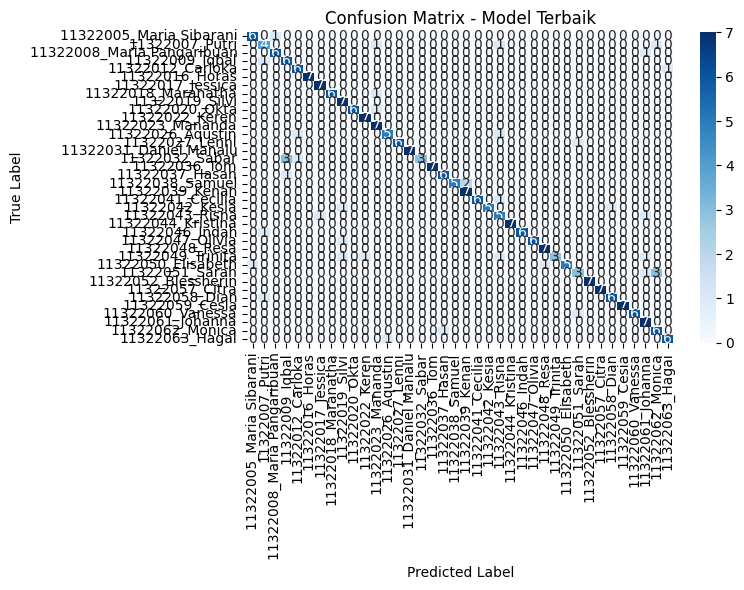

In [15]:
# Ambil label kelas dari train generator
class_labels = list(train_gen.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluasi model terbaik di test set
test_loss, test_acc = model_terbaik.evaluate(test_gen, verbose=0)
print(f"\n Akurasi test: {test_acc * 100:.2f}%")
print(f"Loss test: {test_loss:.4f}")

# Prediksi
y_pred_prob = model_terbaik.predict(test_gen, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes  # Pastikan test_gen tidak di-shuffle

# === Classification Report ===
print("\n Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model Terbaik')
plt.tight_layout()
plt.show()

## Percobaan

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# Load model terbaik dan class labels
model_terbaik = load_model("model/model_eksperimen_7.keras")
class_labels = list(train_gen.class_indices.keys())

# Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

IMG_SIZE = 224
folder_path = "data_uji"

for file_name in os.listdir(folder_path):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(folder_path, file_name)
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        for (x, y, w, h) in faces:
            face = img[y:y+h, x:x+w]
            face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
            face = face.astype("float32") / 255.0
            face = img_to_array(face)
            face = np.expand_dims(face, axis=0)

            pred = model_terbaik.predict(face, verbose=0)
            label = class_labels[np.argmax(pred)]

            # Gambar bounding box dan label
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

        # Konversi ke RGB agar tampil benar di matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Tampilkan di bawah
        plt.figure(figsize=(6, 6))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Hasil Deteksi: {file_name}")
        plt.show()
